### JWST Pipeline Processing of Wide Field Slitless Spectroscopy Exposures


#### Calspec2 steps       
    
- assign_wcs: Assigns a WCS object to dispersed exposures              
- background: Background subtraction                
- flatfield: Flat fielding             
- extract_2d: Extract cutouts  
- photom: Photometric correction      
- extract_1d: Extract 1D spectrum   


#### Calspec3 steps
 
- exp_to_source: Reformat files to contain one source from multiple exposures
- extract_1d: Final 1D extraction    
- combine_1d: Combine 1D spectra     


#### assign_wcs

The *assign_wcs* step creates and assigns a WCS to each SCI exposure. The JWST pipeline uses gWCS (more flexible than FITS WCS) to perform the transformations and the ASDF standard to save the WCS to a file. 

The reference files contain the calibrated distortion models and wavelength solutions and are also saved in the ASDF format in the [JWST CRDS](https://jwst-crds.stsci.edu).

*assign_wcs* operates on single SCI exposures using a previously created catalog of objects. The name of the catalog is saved as a keyword in the primary FITS header of the SCI file.
Essentially the pipeline runs first calimage2 on the direct images in an association, adds the name of the catalog file to the association and saves it in the dispersed image header. At this point calspec2 runs on the dispersed image. This notebook describes the steps in calspec2.


A simulated NIRCAM grism image is used in the examples. 

In [1]:
fname = "jw01076006002_0117x_00003_nrcb5_uncal_dispersed_GRISMR_crossing_F444W_assign_wcs.fits"

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import patches

In [3]:
import asdf
import numpy as np

from astropy.modeling.models import *
from astropy.modeling.models import math as astmath

from jwst import datamodels
from jwst.assign_wcs import util
from jwst.assign_wcs import nircam
from jwst.transforms.models import (NIRCAMForwardRowGrismDispersion,
                                    NIRCAMBackwardGrismDispersion)

from gwcs import coordinate_frames as cf
from astropy import units as u

#### Read the data from the reference file

The `distortion` reference file contains the distortion models used in imaging mode.

The `specwcs` reference file contains the transforms between the direct and dispersed images.

The `wavelengthrange` reference file contains the wavelength limits to use when calculating the minimum and maximum dispersion extents on the detector. It also contains the default list of orders that should be extracted for each filter.

In [4]:
reference_files = {
    'distortion': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_distortion_0096.asdf',
    'specwcs': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_specwcs_0009.asdf',
    'wavelengthrange': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf',
    'filteroffset': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_filteroffset_0001.asdf'
    }


specwcs = asdf.open(reference_files['specwcs']).tree
displ = specwcs['displ']
dispx = specwcs['dispx']
dispy = specwcs['dispy']
invdispl = specwcs['invdispl']
invdispx = specwcs['invdispx']
invdispy = specwcs['invdispy']
orders = specwcs['orders']

print('orders', orders)
print('dispersion_wavelength', displ)



orders [1, 2]
dispersion_wavelength [<Polynomial1D(1, c0=2.4, c1=2.6)>, <Polynomial1D(1, c0=2.4, c1=2.6)>]


#### Construct the WCS pipeline

The code snippet below shows two of the major advantages of gWCS to FITS WCS:

- Combine arbitrary transforms in an arbitrary way.

- The WCS pipeline is a list of steps where each step is defined by a coordinate system and the transform to the next coordinate system in the WCS pipeline, **(coord_frame, transform)**.There are tools to create custom coordinate frames to be used as intermediate frames in the WCS pipeline. Furthermore, one can retrieve the transform between any two  frames. This, essentially, provides an opportunity for WCS designers to choose places (stops) in the WCS pipeline where it makes sense to provide the user with the option to compute intermediate results.

Here we call a class which constructs the pipeline. At the end of the notebook there's a functional form of this class to illustrate what it is doing under the hood.

In [5]:
# open the dispersed exposure
input_model = datamodels.open(fname)

In [6]:
''''''
refs = {}
from jwst.assign_wcs import AssignWcsStep
astep = AssignWcsStep()
for t in astep.reference_file_types:
    refs[t] = astep.get_reference_file(input_model, t)
''''''

2020-06-30 22:04:49,407 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


''

In [7]:
#print(refs)

The WCS will go roughly through these steps (in reverse order):

sky --> direct_image --> dispersed_image

The imaging part of the WCS uses the distortion for imaging mode. This is created in the same way as regular images.

In [8]:
image_pipeline = nircam.imaging(input_model, reference_files)
print(image_pipeline[2])

(<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>, None)


Now let's create a custom coordinate frame associated with the grism image.

In [9]:
gdetector = cf.Frame2D(name='grism_detector', 
                       axes_order=(0, 1),
                       unit=(u.pix, u.pix))

Create the transform between the grism detector and the direct image detector.

It will take as inputs 

- xgrism, ygrism: x, y coordinates in the grism image
- x0, y0: center of an object (from catalog or user supplied)
- order: spectral order

It will return

- xdirect, ydirect: x0, y0
- lam: wavelength
- order: spectral order

In [10]:
det2det = NIRCAMForwardRowGrismDispersion(orders,
                                          lmodels=displ,
                                          xmodels=invdispx,
                                          ymodels=dispy)

And assign an inverse to this transform.
The inverse transform takes inputs:

- xdirect, ydirect
- wavelength
- order

It returns

- xdispersed, ydispersed
- x0, y0
- order


In [11]:
det2det.inverse = NIRCAMBackwardGrismDispersion(orders,
                                                    lmodels=invdispl,
                                                    xmodels=dispx,
                                                    ymodels=dispy)

In [12]:
grism_pipeline = [(gdetector, det2det)]

imagepipe = []
world = image_pipeline.pop()
for cframe, trans in image_pipeline:
    trans = trans & (Identity(2))
    imagepipe.append((cframe, trans))
imagepipe.append((world))
grism_pipeline.extend(imagepipe)


The final WCS object.

Inputs are (x_dispersed, y_dispersed, x0, y0, order).

Outputs are RA, DEC, wavelength, order

In [13]:
from gwcs import WCS

wcsobj = WCS(grism_pipeline)
print(wcsobj)


     From                   Transform             
-------------- -----------------------------------
grism_detector nircam_forward_row_grism_dispersion
      detector                       CompoundModel
          v2v3                       CompoundModel
         world                                None


### Direct image

In [14]:
direct = 'jw01076006002_0117y_00004_nrcb5_cal.fits'
im=datamodels.open(direct)
im.data.mean()
#plt.imshow(im.data, aspect='auto', vmin=.2, vmax=.65)
for slit in x2d.slits:
    bbox = slit.meta.wcs.bounding_box
    xstart, ystart = slit.xstart, slit.ystart
    #print('xstart  ', xstart, ystart)
    ax.add_patch(patches.Rectangle((bbox[0][0]+xstart, bbox[1][0]+ystart), 
                                   bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                  fill=False))
    
ax.imshow(input_model.data, aspect='auto', vmin=-.4, vmax=4, origin='lower')
pos = np.array([(s.source_xpos, s.source_ypos) for s in x2d.slits])
ax.scatter(pos[:,0], pos[:,1], c='r',)

NameError: name 'x2d' is not defined

#### Working with the WCS object

In [16]:
x0=917
y0=800
order=1
x=919
y=806

print("RA, DEC, lam for order=1 :")
print(wcsobj(x, y, x0, y0, 1))

print("RA, DEC, lam for order=2 :")
print(wcsobj(x, y, x0, y0, 2))

2020-06-30 22:05:31,307 - stpipe - WARNING - /anaconda3/envs/astropy41dev/lib/python3.6/site-packages/astropy-4.2.dev266+gd6eabbebe-py3.6-macosx-10.9-x86_64.egg/astropy/modeling/math_functions.py:54: AstropyUserWarning: Models in math_functions are experimental.
  warnings.warn("Models in math_functions are experimental.", AstropyUserWarning)



RA, DEC, lam for order=1 :
(80.96491020650988, -70.07637313843853, 3.934991999972275, 1.0)
RA, DEC, lam for order=2 :
(80.96491020650988, -70.07637313843853, 1.9674960000086115, 2.0)


Now let's see how to get x, y, in the dispersed image. We can retrieve a transform between any two coordinate frames in the pipeline.

In [17]:
wcsobj.available_frames

['grism_detector', 'detector', 'v2v3', 'world']

In [18]:
grism2image = wcsobj.get_transform('grism_detector', 'detector')

x, y, wav, order = grism2image(x, y, x0, y0, order)
print(x, y, wav, order)

917.0 800.0 3.934991999972275 1.0


In [19]:
grism2image.inverse(917, 800, 3.934991999972275, 1)

(918.9999999999998, 800.0, 917.0, 800.0, 1.0)

*assign_wcs* works similarly to *grismconf*, the packaging of reference files and code organization is different.

#### Background subtraction

For Wide-Field Slitless Spectroscopy expsoures, a background reference image is subtracted from the target exposure. Before being subtracted, the background reference image is scaled to match the signal level in the dispersed science image within background (source-free) regions of that image.

More details on the background subtraction step are in the [documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/description.html#wfss-mode).

#### Flat field

The flat field step divides a flat image from the grism image. 
Nircam uses a single grism reference flat image. Niriss has separate flats per filter that are paired with each grism. 


#### extract_2d

Uses the source catalog specified in the SCI header.
Alternatively a user can specify a list of grism objects. A [grism object](https://github.com/spacetelescope/jwst/blob/085801ffaed3df70d4013c3936f0bcde74646eb7/jwst/transforms/models.py#L46) is a named tuple which stores information about a dispersed object.

The sensitivity information from the original aXe style configuration file needs to be modified by the passband of the filter used for the direct image to get the min and max wavelengths which correspond to t=0 and t=1. This has been done by the team and the min and max wavelengths to use to calculate t are stored in the grism wavelengthrange reference file. The min and max wavelength are used in conjunction with the minimum bounding box corners from the catalog to find the extent of the bounding box for the object in the grism image.

Steps in extract_2d:

- Read the catalog and create a list of [sky objects](https://github.com/spacetelescope/jwst/blob/master/jwst/assign_wcs/util.py#L408)
- Create a bounding box for each spectrum.
  The footprint of the object on the sky is passed through the inverse WCS of the
  direct image and then trhough the trace polynomials to find the location of the
  corners on the dispersed image.
- The center of the object in the direct image frame is computed by evaluating the 
  inverse WCS of the direct image on the sky centroid
- The data arrays are extracted using the bounding_box for each spectral_order

In [20]:
wcsobj.available_frames

['grism_detector', 'detector', 'v2v3', 'world']

In [21]:
skyobject_list = util.get_object_info(input_model.meta.source_catalog)
print(skyobject_list[0])

id: 1
xcentroid: 359.6047 pix
ycentroid: 4.6666 pix
sky_centroid: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98653438, -70.09202758)>
isophotal_abmag: 20.264795
isophotal_abmag_err: nan
sky_bbox_ll: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98676416, -70.09209786)>
sky_bbox_lr: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98620738, -70.09206402)>
sky_bbox_ul: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98684545, -70.09194274)>
sky_bbox_ur: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98628868, -70.0919089)>



In [22]:
len(skyobject_list)


971

In [24]:
# Create the bounding_box of each object in the dispersed image
grism_objects = util.create_grism_bbox(input_model, reference_files,
                                       extract_orders=[1],
                                       mmag_extract=18)

2020-06-30 22:05:55,502 - stpipe - INFO - Extracting objects < abmag = 18
2020-06-30 22:05:55,503 - stpipe - INFO - Getting objects from jw01076006002_0117y_00004_nrcb5_cat.ecsv
2020-06-30 22:05:56,424 - stpipe - INFO - Partial order on detector for obj: 10 order: 1
2020-06-30 22:05:56,439 - stpipe - INFO - Partial order on detector for obj: 44 order: 1
2020-06-30 22:05:56,456 - stpipe - INFO - Partial order on detector for obj: 56 order: 1
2020-06-30 22:05:56,489 - stpipe - INFO - Partial order on detector for obj: 103 order: 1
2020-06-30 22:05:56,508 - stpipe - INFO - Partial order on detector for obj: 148 order: 1
2020-06-30 22:05:56,547 - stpipe - INFO - Partial order on detector for obj: 208 order: 1
2020-06-30 22:05:56,566 - stpipe - INFO - Partial order on detector for obj: 265 order: 1
2020-06-30 22:05:56,585 - stpipe - INFO - Partial order on detector for obj: 285 order: 1
2020-06-30 22:05:56,604 - stpipe - INFO - Partial order on detector for obj: 298 order: 1
2020-06-30 22:0

bounding_box set to (14, 51) (-116, 1121)
bounding_box set to (85, 113) (956, 2185)
bounding_box set to (124, 139) (-710, 508)
bounding_box set to (194, 224) (324, 1558)
bounding_box set to (230, 291) (-327, 925)
bounding_box set to (317, 405) (948, 2283)
bounding_box set to (372, 394) (700, 1921)
bounding_box set to (452, 475) (-6, 1216)
bounding_box set to (574, 591) (-705, 514)
bounding_box set to (600, 630) (849, 2084)
bounding_box set to (618, 638) (1007, 2229)
bounding_box set to (626, 649) (-738, 486)


2020-06-30 22:05:56,647 - stpipe - INFO - Partial order on detector for obj: 318 order: 1
2020-06-30 22:05:56,692 - stpipe - INFO - Partial order on detector for obj: 327 order: 1
2020-06-30 22:05:56,715 - stpipe - INFO - Partial order on detector for obj: 350 order: 1
2020-06-30 22:05:56,739 - stpipe - INFO - Partial order on detector for obj: 351 order: 1
2020-06-30 22:05:56,763 - stpipe - INFO - Partial order on detector for obj: 355 order: 1
2020-06-30 22:05:56,784 - stpipe - INFO - Partial order on detector for obj: 372 order: 1
2020-06-30 22:05:56,826 - stpipe - INFO - Partial order on detector for obj: 403 order: 1
2020-06-30 22:05:56,845 - stpipe - INFO - Partial order on detector for obj: 416 order: 1


bounding_box set to (668, 691) (-834, 390)
bounding_box set to (673, 703) (397, 1631)
bounding_box set to (683, 708) (-327, 902)
bounding_box set to (722, 749) (-270, 962)
bounding_box set to (725, 750) (-206, 1022)
bounding_box set to (734, 765) (-621, 615)
bounding_box set to (758, 776) (-892, 323)
bounding_box set to (805, 863) (277, 1543)
bounding_box set to (824, 848) (-909, 313)
bounding_box set to (842, 858) (897, 2117)


2020-06-30 22:05:56,864 - stpipe - INFO - Partial order on detector for obj: 427 order: 1
2020-06-30 22:05:56,885 - stpipe - INFO - Partial order on detector for obj: 438 order: 1
2020-06-30 22:05:56,922 - stpipe - INFO - Partial order on detector for obj: 518 order: 1
2020-06-30 22:05:56,943 - stpipe - INFO - Partial order on detector for obj: 535 order: 1
2020-06-30 22:05:57,000 - stpipe - INFO - Partial order on detector for obj: 567 order: 1
2020-06-30 22:05:57,017 - stpipe - INFO - Partial order on detector for obj: 573 order: 1
2020-06-30 22:05:57,038 - stpipe - INFO - Partial order on detector for obj: 642 order: 1
2020-06-30 22:05:57,057 - stpipe - INFO - Partial order on detector for obj: 649 order: 1
2020-06-30 22:05:57,077 - stpipe - INFO - Partial order on detector for obj: 650 order: 1


bounding_box set to (880, 901) (-424, 805)
bounding_box set to (903, 937) (949, 2184)
bounding_box set to (948, 986) (510, 1762)
bounding_box set to (1052, 1072) (-597, 621)
bounding_box set to (1082, 1135) (-660, 603)
bounding_box set to (1087, 1109) (788, 2010)
bounding_box set to (1110, 1121) (268, 1477)
bounding_box set to (1146, 1174) (-426, 804)
bounding_box set to (1182, 1214) (-792, 442)
bounding_box set to (1317, 1348) (-601, 634)
bounding_box set to (1335, 1366) (-169, 1060)
bounding_box set to (1336, 1356) (-213, 1007)


2020-06-30 22:05:57,106 - stpipe - INFO - Partial order on detector for obj: 655 order: 1
2020-06-30 22:05:57,130 - stpipe - INFO - Partial order on detector for obj: 665 order: 1
2020-06-30 22:05:57,151 - stpipe - INFO - Partial order on detector for obj: 696 order: 1
2020-06-30 22:05:57,172 - stpipe - INFO - Partial order on detector for obj: 703 order: 1
2020-06-30 22:05:57,234 - stpipe - INFO - Partial order on detector for obj: 759 order: 1


bounding_box set to (1347, 1383) (-827, 408)
bounding_box set to (1376, 1414) (-888, 332)
bounding_box set to (1420, 1442) (-390, 829)
bounding_box set to (1428, 1469) (1047, 2283)
bounding_box set to (1521, 1536) (235, 1451)
bounding_box set to (1531, 1549) (416, 1633)
bounding_box set to (1562, 1599) (-237, 1018)
bounding_box set to (1592, 1613) (637, 1861)
bounding_box set to (1677, 1698) (633, 1851)
bounding_box set to (1680, 1712) (379, 1615)
bounding_box set to (1763, 1787) (285, 1507)
bounding_box set to (1780, 1816) (101, 1344)
bounding_box set to

2020-06-30 22:05:57,339 - stpipe - INFO - Partial order on detector for obj: 867 order: 1
2020-06-30 22:05:57,388 - stpipe - INFO - Partial order on detector for obj: 893 order: 1
2020-06-30 22:05:57,419 - stpipe - INFO - Partial order on detector for obj: 910 order: 1


 (1782, 1797) (395, 1625)
bounding_box set to (1781, 1812) (857, 2094)
bounding_box set to (1810, 1833) (76, 1297)
bounding_box set to (1828, 1847) (492, 1713)
bounding_box set to (1838, 1861) (-551, 674)
bounding_box set to (1870, 1900) (582, 1807)
bounding_box set to (1876, 1911) (818, 2059)
bounding_box set to (1960, 2000) (413, 1644)


In [25]:
print('number of grism objects:', len(grism_objects))


number of grism objects: 54


In [26]:
print(grism_objects[0])

id: 10
order_bounding {1: ((14, 51), (-116, 1121))}
sky_centroid: <SkyCoord (ICRS): (ra, dec) in deg
    (80.96058262, -70.08991424)>
sky_bbox_ll: <SkyCoord (ICRS): (ra, dec) in deg
    (80.96149237, -70.09029352)>
sky_bbox_lr: <SkyCoord (ICRS): (ra, dec) in deg
    (80.95941744, -70.09016711)>
sky_bbox_ur: <SkyCoord (ICRS): (ra, dec) in deg
    (80.95975245, -70.08952945)>
sky_bbox_ul:<SkyCoord (ICRS): (ra, dec) in deg
    (80.96182732, -70.08965586)>
xcentroid: 863.9608202943069
ycentroid: 33.88426608296754
partial_order: {1: True}
waverange: {1: (3.696969216, 4.899565197)}



In [27]:
print('order, y_bbox, x_bbox')
[g.order_bounding for g in grism_objects[:3]]

order, y_bbox, x_bbox


[{1: ((14, 51), (-116, 1121))},
 {1: ((85, 113), (956, 2185))},
 {1: ((124, 139), (-710, 508))}]

In [28]:
#x2d = datamodels.open('nrc_dispersed_extract_2d.fits')
x2d = datamodels.open('x2d_mmag18.fits')


In [29]:
len(x2d.slits)
#x2d.meta.wcsinfo._instance

54

<IPython.core.display.Javascript object>


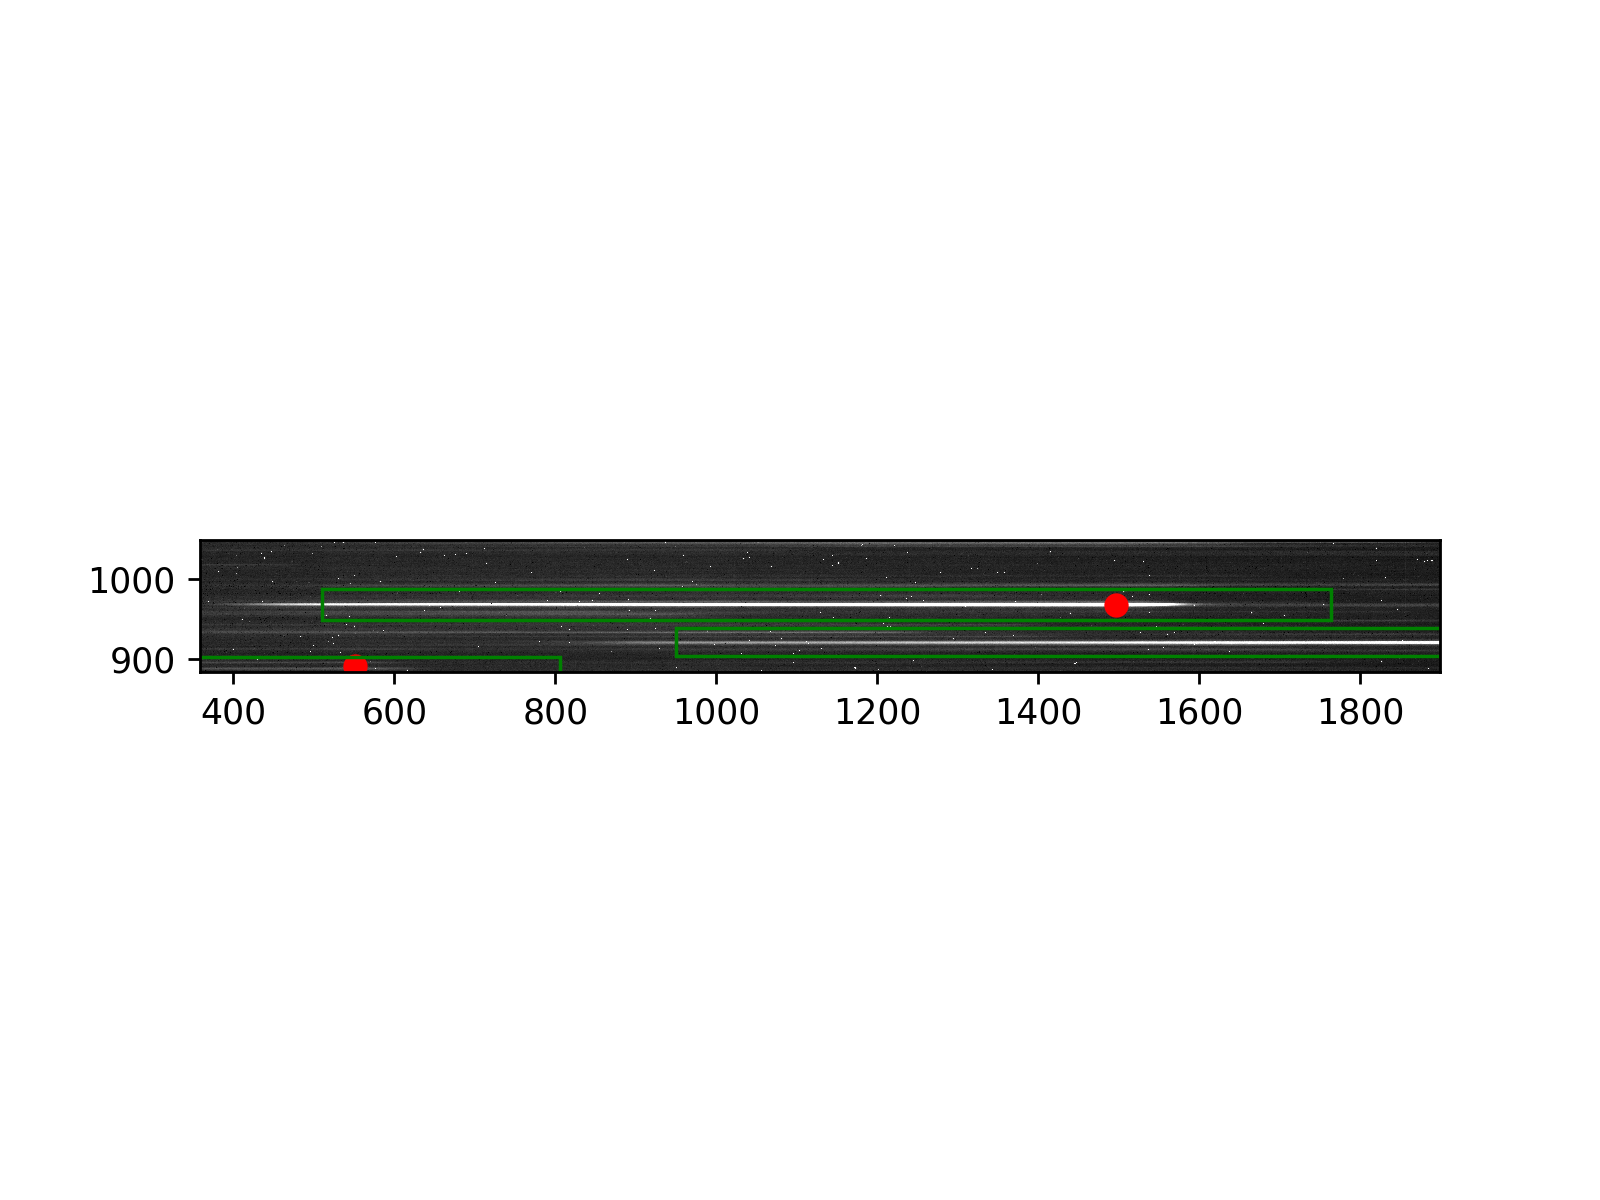

xstart   1 15
bbox ((-0.5, 1121.5), (-0.5, 37.5))
xstart   957 86
bbox ((-0.5, 1091.5), (-0.5, 28.5))
xstart   1 125
bbox ((-0.5, 508.5), (-0.5, 15.5))
xstart   325 195
bbox ((-0.5, 1234.5), (-0.5, 30.5))
xstart   1 231
bbox ((-0.5, 925.5), (-0.5, 61.5))
xstart   949 318
bbox ((-0.5, 1099.5), (-0.5, 88.5))
xstart   701 373
bbox ((-0.5, 1221.5), (-0.5, 22.5))
xstart   1 453
bbox ((-0.5, 1216.5), (-0.5, 23.5))
xstart   1 575
bbox ((-0.5, 514.5), (-0.5, 17.5))
xstart   850 601
bbox ((-0.5, 1198.5), (-0.5, 30.5))
xstart   1008 619
bbox ((-0.5, 1040.5), (-0.5, 20.5))
xstart   1 627
bbox ((-0.5, 486.5), (-0.5, 23.5))
xstart   1 669
bbox ((-0.5, 390.5), (-0.5, 23.5))
xstart   398 674
bbox ((-0.5, 1234.5), (-0.5, 30.5))
xstart   1 684
bbox ((-0.5, 902.5), (-0.5, 25.5))
xstart   1 723
bbox ((-0.5, 962.5), (-0.5, 27.5))
xstart   1 726
bbox ((-0.5, 1022.5), (-0.5, 25.5))
xstart   1 735
bbox ((-0.5, 615.5), (-0.5, 31.5))
xstart   1 759
bbox ((-0.5, 323.5), (-0.5, 18.5))
xstart   278 806
bbox ((-0.

In [30]:
ax = plt.subplot(111)
plt.gray()

for slit in x2d.slits:
    bbox = slit.meta.wcs.bounding_box
    xstart, ystart = slit.xstart, slit.ystart
    print('xstart  ', xstart, ystart)
    print('bbox', bbox)
    ax.add_patch(patches.Rectangle((bbox[0][0]+xstart, bbox[1][0]+ystart), 
                                   bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                  fill=False))
    #ax.add_patch(patches.Rectangle((bbox[0][0], bbox[1][0]), 
    #                               bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
    #                               fill=False))
    
ax.imshow(input_model.data, aspect='auto', vmin=-.4, vmax=4, origin='lower')
pos = np.array([(s.source_xpos, s.source_ypos) for s in x2d.slits])
ax.scatter(pos[:,0], pos[:,1], c='r',)

In [35]:
s0 = x2d.slits[0]
bbox = s0.meta.wcs.bounding_box
xstart, ystart = s0.xstart, s0.ystart
print('bbox', bbox, xstart, ystart)

bbox ((-0.5, 1121.5), (-0.5, 37.5)) 1 15


In [36]:
ax = plt.subplot(111)

ax.add_patch(patches.Rectangle((bbox[0][0], bbox[1][0]), 
                                bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                fill=False))
plt.imshow(s0.data, origin='lower')
plt.scatter(s0.source_xpos-xstart, s0.source_ypos-ystart, c='r')

2020-06-30 22:14:36,249 - stpipe - WARNING - /anaconda3/envs/astropy41dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.



#### extract_1d

The photometric correction is done before extract_1d is run.

The extraction region is taken to be the full size of the input subarray or cutout, or it could be restricted to the region within which the world coordinate system is defined. 

Optimal extraction is not implemented in the pipeline yet.

### The grism transforms in detail

In [ ]:


order = 1
xmodel = invdispx[order -1]
ymodel = dispy[order-1]
lmodel = displ[order-1]

In [ ]:
t = xmodel(x-x0)
dy = ymodel(t)
wav = lmodel(t)
print(x0, y0+dy, wav, order,t)

In [ ]:
# inverse
t = lmodel(wav)
dx = xmodel(t)
dy = ymodel(t)
# return x+dx, y+dy, x, y, order
print(dx, dy, x, y, order)

In [ ]:
# Compute the **t** parameter described in grismconf. 
# For a row dispersed image it is xdirect - x0
tmodel = astmath.SubtractUfunc() | xmodel

# The displacement in y is computed by passing **t** as input to the dispy polynomial

dy = tmodel| ymodel
dl = tmodel | lmodel

# inputs are xirect, ydirect, x0, y0, order

model = Mapping((0, 2, 0, 2, 2, 3, 4)) | \

# inputs are xdirect, x0,     xdirect, x0,      x0, y0, order
        (tmodel | ymodel) & (tmodel | lmodel) & Identity(3) |\

# inputs are dy, dl, x0, y0, order
        Mapping((2, 3, 0, 1, 4)) | \

# inputs are x0,     y0, dy,                dl, order
        Identity(1) & astmath.AddUfunc() &  Identity(2)

# outputs are x0, y0 + dy, dl, order)

In [ ]:
print(dispy)